In [1]:
#Importing the required modules, the ones I remember
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
#Loading the data, preprocessing
from google.colab import files
uploaded = files.upload()

Saving AustriaNew.csv to AustriaNew.csv


In [3]:
import io
dataRequired = pd.read_csv(io.BytesIO(uploaded['AustriaNew.csv']))
dataRequired.head()

,Unnamed: 0,index,AT_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal
0,0,87656,7035.0,6343.0,36.0,2.0,109.0,3.27,-4.179,1.5614,25.9639
1,1,87657,7394.0,6882.0,41.0,10.0,146.0,3.23,-2.807,7.5467,75.0443
2,2,87658,7770.0,6963.0,45.0,21.0,146.0,3.22,-1.315,17.2073,116.9171
3,3,87659,7820.0,7110.0,50.0,32.0,158.0,3.22,-0.051,35.4289,146.8923
4,4,87660,7694.0,7136.0,51.0,37.0,187.0,3.00,0.791,58.5238,151.4721


In [4]:
dataRequired.shape

(17488, 11)

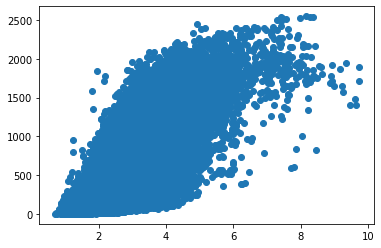

In [5]:
#Plotting and visualising the time series relation
plt.scatter(dataRequired['AT_windspeed_10m'],dataRequired['AT_wind_onshore_generation_actual'])

In [6]:
#Clearly, the characteristics resemble the expected characteristics, but the data had quite a bit of deviation about the standard curve.
#It can be clearly attributed to variations in density of the air density, due to radiation changes throughout the year.

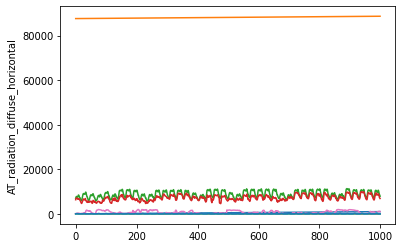

In [8]:
#Plotting the time series
for i in dataRequired:
  plt.ylabel(i)
  plt.plot(dataRequired[i][:1000])

In [9]:
# Certain periodic trends are found in the data, also, the series appear sufficiently correlated with one another, we thus use an LSTM for training the model

In [11]:
#Converting the time series analysis problem into a supervised learning problem
def seriesToSupervised(data, lookBack = 60, predCols = 1):
  temp = data.copy()
  temp['id'] = range(1, len(temp)+1)
  temp = temp.iloc[: -lookBack, :]
  temp.set_index('id', inplace = True)
  predVal = data.copy()
  predVal = predVal.iloc[lookBack:, predCols]
  predVal.columns = ['Pred']
  predVal = pd.DataFrame(predVal)
  predVal['id'] = range(1, len(predVal)+1)
  predVal.set_index('id', inplace = True)
  finalDf = pd.concat([temp, predVal], axis = 1)
  return finalDf

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Solar energy output forecasting



In [13]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredSolarOutput=dataRequired[['AT_solar_generation_actual', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredSolarOutput['pred'] = dataPredSolarOutput['AT_solar_generation_actual'].shift(-1)
dataPredSolarOutput = dataPredSolarOutput.dropna()
dataPredSolarOutput.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_solar_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,2.0,3.27,-4.179,1.5614,25.9639,10.0
1,10.0,3.23,-2.807,7.5467,75.0443,21.0
2,21.0,3.22,-1.315,17.2073,116.9171,32.0
3,32.0,3.22,-0.051,35.4289,146.8923,37.0
4,37.0,3.00,0.791,58.5238,151.4721,35.0


In [14]:
scalerOne = MinMaxScaler(feature_range=(0,1))
solarScaled = scalerOne.fit_transform(dataPredSolarOutput.values)
solarScaled = pd.DataFrame(solarScaled)

In [15]:
solarScaled.head()

,0,1,2,3,4,5
0,0.003279,0.285083,0.178747,0.001814,0.064377,0.016393
1,0.016393,0.280663,0.209402,0.008767,0.186070,0.034426
2,0.034426,0.279558,0.242738,0.019991,0.289892,0.052459
3,0.052459,0.279558,0.270980,0.041160,0.364214,0.060656
4,0.060656,0.255249,0.289794,0.067990,0.375570,0.057377


In [16]:
arrDfSolar = seriesToSupervised(solarScaled, 3, 0)
arrDfSolar.fillna(0, inplace = True)
arrDfSolar.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.003279,0.285083,0.178747,0.001814,0.064377,0.016393,0.052459
2,0.016393,0.280663,0.209402,0.008767,0.186070,0.034426,0.060656
3,0.034426,0.279558,0.242738,0.019991,0.289892,0.052459,0.057377
4,0.052459,0.279558,0.270980,0.041160,0.364214,0.060656,0.044262
5,0.060656,0.255249,0.289794,0.067990,0.375570,0.057377,0.022951


In [23]:
# splitting and converting the data to right shape, around 80:20 ratio would be good for validation
values = arrDfSolar.values
trainSample = int(len(dataPredSolarOutput)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [24]:
# We need a 3D data as (sample size, look back steps, input features)
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [20]:
model = Sequential()
model.add(LSTM(75, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 30))
model.add(Dense(units = 1))
model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 75)             24600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             25200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 59,551
Trainable params: 59,551
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 3s 286us/step - loss: 0.0802 - val_loss: 0.1194
Epoch 2/50
11191/11191 [==============================] - 2s 162us/step - loss: 0.0456 - val_loss: 0.0685
Epoch 3/50
11191/11191 [==============================] - 2s 159us/step - loss: 0.0379 - val_loss: 0.0628
Epoch 4/50
11191/11191 [==============================] - 2s 154us/step - loss: 0.0353 - val_loss: 0.0559
Epoch 5/50
11191/11191 [==============================] - 2s 156us/step - loss: 0.0347 - val_loss: 0.0555
Epoch 6/50
11191/11191 [==============================] - 2s 154us/step - loss: 0.0347 - val_loss: 0.0612
Epoch 7/50
11191/11191 [==============================] - 2s 157us/step - loss: 0.0341 - val_loss: 0.0528
Epoch 8/50
11191/11191 [==============================] - 2s 155us/step - loss: 0.0338 - val_loss: 0.0548
Epoch 9/50
11191/11191 [==============================] - 2s 162us/step - loss: 0.0329 - val_loss: 0.04

In [25]:
#Making predictions
yPred = model.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerOne.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerOne.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 19.775166717056553
Mean squared error 933.6409925913919
R2_Score 0.9508655187658521


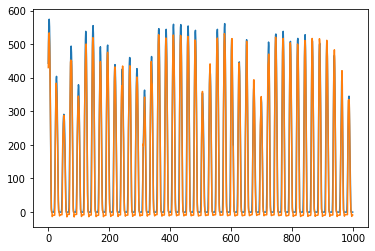

In [26]:
plt.plot(invyTest[:1000])
plt.plot(invyPred[:1000])

# Wind energy output forecasting


In [27]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredWindOutput = dataRequired[['AT_wind_onshore_generation_actual', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredWindOutput['pred'] = dataPredWindOutput['AT_wind_onshore_generation_actual'].shift(-1)
dataPredWindOutput = dataPredWindOutput.dropna()
dataPredWindOutput.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_wind_onshore_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,109.0,3.27,-4.179,1.5614,25.9639,146.0
1,146.0,3.23,-2.807,7.5467,75.0443,146.0
2,146.0,3.22,-1.315,17.2073,116.9171,158.0
3,158.0,3.22,-0.051,35.4289,146.8923,187.0
4,187.0,3.00,0.791,58.5238,151.4721,244.0


In [28]:
scalerTwo = MinMaxScaler(feature_range=(0,1))
windScaled = scalerTwo.fit_transform(dataPredWindOutput.values)
windScaled = pd.DataFrame(windScaled)
windScaled.head()

,0,1,2,3,4,5
0,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277
1,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277
2,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985
3,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362
4,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724


In [29]:
arrDfWind = seriesToSupervised(windScaled, 3, 0)
arrDfWind.fillna(0, inplace = True)
arrDfWind.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277,0.061985
2,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277,0.073362
3,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985,0.095724
4,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362,0.117301
5,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724,0.128286


In [30]:
values = arrDfWind.values
trainSample = int(len(dataPredWindOutput)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [31]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [32]:
modelOne = Sequential()
modelOne.add(LSTM(128, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
modelOne.add(LSTM(units = 64, return_sequences=True))
modelOne.add(LSTM(units = 32))
modelOne.add(Dense(units = 1))
modelOne.compile(loss = 'mae', optimizer = 'adam')
modelOne.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 128)            69120     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = modelOne.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 3s 306us/step - loss: 0.0870 - val_loss: 0.0608
Epoch 2/50
11191/11191 [==============================] - 2s 189us/step - loss: 0.0584 - val_loss: 0.0558
Epoch 3/50
11191/11191 [==============================] - 2s 190us/step - loss: 0.0556 - val_loss: 0.0533
Epoch 4/50
11191/11191 [==============================] - 2s 196us/step - loss: 0.0532 - val_loss: 0.0524
Epoch 5/50
11191/11191 [==============================] - 2s 192us/step - loss: 0.0521 - val_loss: 0.0508
Epoch 6/50
11191/11191 [==============================] - 2s 189us/step - loss: 0.0511 - val_loss: 0.0521
Epoch 7/50
11191/11191 [==============================] - 2s 194us/step - loss: 0.0506 - val_loss: 0.0552
Epoch 8/50
11191/11191 [==============================] - 2s 193us/step - loss: 0.0501 - val_loss: 0.0545
Epoch 9/50
11191/11191 [==============================] - 2s 197us/step - loss: 0.0500 - val_loss: 0.05

In [34]:
#Making predictions
yPred = modelOne.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerTwo.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerTwo.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 107.48180423247307
Mean squared error 28092.957266278256
R2_Score 0.9295892880774494


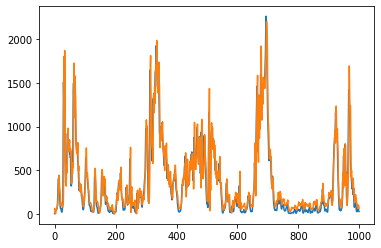

In [35]:
plt.plot(invyTest[:1000])
plt.plot(invyPred[:1000])

# Demand forecasting model



In [36]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredDemand = dataRequired[['AT_load_actual_entsoe_power_statistics', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredDemand['pred'] = dataPredDemand['AT_load_actual_entsoe_power_statistics'].shift(-1)
dataPredDemand = dataPredDemand.dropna()
dataPredDemand.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_load_actual_entsoe_power_statistics,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,7035.0,3.27,-4.179,1.5614,25.9639,7394.0
1,7394.0,3.23,-2.807,7.5467,75.0443,7770.0
2,7770.0,3.22,-1.315,17.2073,116.9171,7820.0
3,7820.0,3.22,-0.051,35.4289,146.8923,7694.0
4,7694.0,3.00,0.791,58.5238,151.4721,7565.0


In [37]:
scalerThree = MinMaxScaler(feature_range=(0,1))
demandScaled = scalerThree.fit_transform(dataPredDemand.values)
demandScaled = pd.DataFrame(windScaled)
demandScaled.head()

,0,1,2,3,4,5
0,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277
1,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277
2,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985
3,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362
4,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724


In [38]:
arrDfDemand = seriesToSupervised(demandScaled, 3, 0)
arrDfDemand.fillna(0, inplace = True)
arrDfDemand.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277,0.061985
2,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277,0.073362
3,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985,0.095724
4,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362,0.117301
5,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724,0.128286


In [39]:
values = arrDfDemand.values
trainSample = int(len(dataPredDemand)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [40]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [41]:
modelTwo = Sequential()
modelTwo.add(LSTM(75, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
modelTwo.add(LSTM(units = 50, return_sequences=True))
modelTwo.add(LSTM(units = 30))
modelTwo.add(Dense(units = 1))
modelTwo.compile(loss = 'mae', optimizer = 'adam')
modelTwo.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 75)             24600     
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 50)             25200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 59,551
Trainable params: 59,551
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = modelTwo.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 3s 277us/step - loss: 0.0928 - val_loss: 0.0614
Epoch 2/50
11191/11191 [==============================] - 2s 165us/step - loss: 0.0588 - val_loss: 0.0572
Epoch 3/50
11191/11191 [==============================] - 2s 157us/step - loss: 0.0560 - val_loss: 0.0547
Epoch 4/50
11191/11191 [==============================] - 2s 152us/step - loss: 0.0542 - val_loss: 0.0532
Epoch 5/50
11191/11191 [==============================] - 2s 157us/step - loss: 0.0522 - val_loss: 0.0516
Epoch 6/50
11191/11191 [==============================] - 2s 155us/step - loss: 0.0509 - val_loss: 0.0508
Epoch 7/50
11191/11191 [==============================] - 2s 156us/step - loss: 0.0501 - val_loss: 0.0522
Epoch 8/50
11191/11191 [==============================] - 2s 157us/step - loss: 0.0498 - val_loss: 0.0523
Epoch 9/50
11191/11191 [==============================] - 2s 158us/step - loss: 0.0496 - val_loss: 0.05

In [43]:
#Making predictions
yPred = modelTwo.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerThree.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerThree.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 296.36897689345477
Mean squared error 214199.11260666736
R2_Score 0.9300967715330862


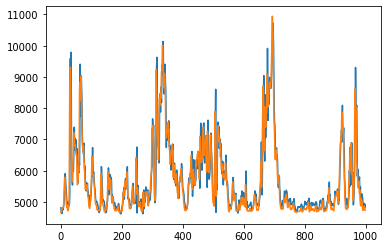

In [44]:
plt.plot(invyPred[:1000])
plt.plot(invyTest[:1000])

# Uplaoding the model parameters to drive


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [46]:
model.save('/content/drive/My Drive/SolarEnergyGenerationForecasting.h5')

In [47]:
modelOne.save('/content/drive/My Drive/WinEnergyGenerationForecasting.h5')

In [48]:
modelTwo.save('/content/drive/My Drive/DemandForecasting.h5')